In [ ]:
# default_exp

# Creating Ambiguous-MNIST for Dirty-MNIST
> Synthesizing an ambiguous version of MNIST step-by-step.

In [ ]:
# hide
# all_slow
from nbdev.showdoc import *

%config Completer.use_jedi = False

## Overview

We train a VAE on the original MNIST dataset to be able to synthesize new MNIST digits. Then, we train an ensemble of LeNet models on MNIST that we can use to select ambiguous samples (low epistemic uncertainty, high aleatoric uncertainty) from the VAE.

To calibrate the VAE's output to match MNIST's unwhitened outputs as much as possible, we synthesize unambiguous digits using the VAE first and then adjust the outputs slightly.

To cover a wider range of entropies, we employ stratified sampling of ambiguous samples while rejecting samples with high epistemic uncertainty (info gain).

We try to different means of sampling from the VAE. The first one samples randomly from the latent space (unit Gaussian). The other method encodes existing MNIST samples into the latent space and then interpolates between them, using Barycentric coordinates. I.e. by randomly picking a convex interpolation.

### Software Engineering

To save progress and resources, we cache most results locally using a helper function `restore_or_create`. We do not upload those snapshots. Only the final AMNIST samples.

## Prerequisites

In [ ]:
import os
from functools import wraps

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import save_image
from tqdm.auto import tqdm

In [ ]:
torch.manual_seed(1)
np.random.seed(1)

# Setup matplotlib to make it easier to copy outputs into Slack (seriously).
plt.rcParams["figure.facecolor"] = "white"

batch_size = 128

Load MNIST:

In [ ]:
mnist_mean, mnist_std = 0.1307, 0.3081

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((mnist_mean,), (mnist_std,))]
)

mnist_train_dataset = datasets.MNIST(
    root="./mnist_data/", train=True, transform=transform, download=True
)
mnist_test_dataset = datasets.MNIST(
    root="./mnist_data/", train=False, transform=transform, download=True
)

mnist_train_loader = torch.utils.data.DataLoader(
    dataset=mnist_train_dataset, batch_size=batch_size, shuffle=True
)
mnist_test_loader = torch.utils.data.DataLoader(
    dataset=mnist_test_dataset, batch_size=batch_size, shuffle=False
)

Two helper functions to unwhiten and whiten MNIST samples.

In [ ]:
def unwhiten_mnist(x):
    return x * mnist_std + mnist_mean

In [ ]:
def whiten_mnist(x):
    return (x - mnist_mean) / mnist_std

Finally, we need a helper function to make it easy to backup and restore resources:

In [ ]:
def restore_or_create(
    file_or_path,
    recreate: bool = False,
    *,
    pickle_module=None,
    pickle_load_args={}
):
    pickle_module_arg = (
        dict(pickle_module=pickle_module) if pickle_module else {}
    )

    def delegate(func):
        @wraps(func)
        def wrapper():
            if not recreate:
                try:
                    return torch.load(
                        file_or_path, {**pickle_load_args, **pickle_module_arg}
                    )
                except FileNotFoundError:
                    pass
            result = func()
            torch.save(
                result, file_or_path, pickle_protocol=-1, **pickle_module_arg
            )
            return result

        return wrapper

    return delegate

## VAE Code

This code is from https://github.com/pytorch/examples/blob/master/vae/main.py.

Note, we train it on whitened MNIST, and have adapted the loss function for that.

In [ ]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()

        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)

    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h)  # mu, log_var

    def sampling(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)  # return z sample

    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return (F.sigmoid(self.fc6(h)) - mnist_mean) / mnist_std

    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

In [ ]:
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(
        unwhiten_mnist(recon_x),
        unwhiten_mnist(x).view(-1, 784),
        reduction="sum",
    )
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [ ]:
def train_vae_epoch(vae, optimizer, train_loader, epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()

        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(
        "====> Epoch: {} Average loss: {:.4f}".format(
            epoch, train_loss / len(train_loader.dataset)
        )
    )

In [ ]:
def test_vae(vae, test_loader):
    vae.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda()
            recon, mu, log_var = vae(data)

            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()

    test_loss /= len(test_loader.dataset)
    print("====> Test set loss: {:.4f}".format(test_loss))

### Training the VAE on MNIST

In [ ]:
@restore_or_create("vae_ambiguous_mnist.model", recreate=False)
def train_vae():
    z_dim = 32
    # build model
    vae = VAE(x_dim=784, h_dim1=512, h_dim2=256, z_dim=z_dim)
    if torch.cuda.is_available():
        vae.cuda()

    optimizer = optim.Adam(vae.parameters())
    scheduler = optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=[25, 50, 65], gamma=0.2
    )

    os.makedirs("./samples", exist_ok=True)
    for epoch in tqdm(range(1, 75)):
        train_vae_epoch(vae, optimizer, mnist_train_loader, epoch)
        test_vae(vae, mnist_test_loader)
        scheduler.step()
        with torch.no_grad():
            z = torch.randn(64, z_dim).cuda()
            # print (z.shape)
            sample = vae.decoder(z).cuda()
            save_image(
                unwhiten_mnist(sample.view(64, 1, 28, 28)),
                "./samples/sample_" + str(epoch) + ".png",
            )

    return vae


vae = train_vae()
vae

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=32, bias=True)
  (fc32): Linear(in_features=256, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

### Visualizing VAE samples

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import PercentFormatter
from torchvision.utils import make_grid


def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation="nearest")

Before we calibrate the VAE properly, we use the following method to post process the samples. 

The original LeNet-5 paper states (using inverted colors):
> The values of the input pixels are normalized
so that the background level (white) corresponds to a value
of -0.1 and the foreground (black) corresponds to 1.175.
This makes the mean input roughly zero and the variance
roughly one, which accelerates learning 

In [ ]:
def post_process_amnist(sample):
    unwhitened = unwhiten_mnist(sample)
    unwhitened = torch.clamp(1.275 * unwhitened - 0.1, 0, 1)
    return unwhitened

Sample images from the latent space and visualize their histogram:

In [ ]:
def pixel_histogram(samples, num_bins):
    train_histogram = np.histogram(
        samples.cpu().flatten().numpy(), bins=num_bins
    )
    print(train_histogram[0] / samples.numel(), train_histogram[1])
    plt.bar(
        train_histogram[1][:-1], train_histogram[0], align="edge", width=0.05
    )
    plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=samples.numel()))
    plt.show()

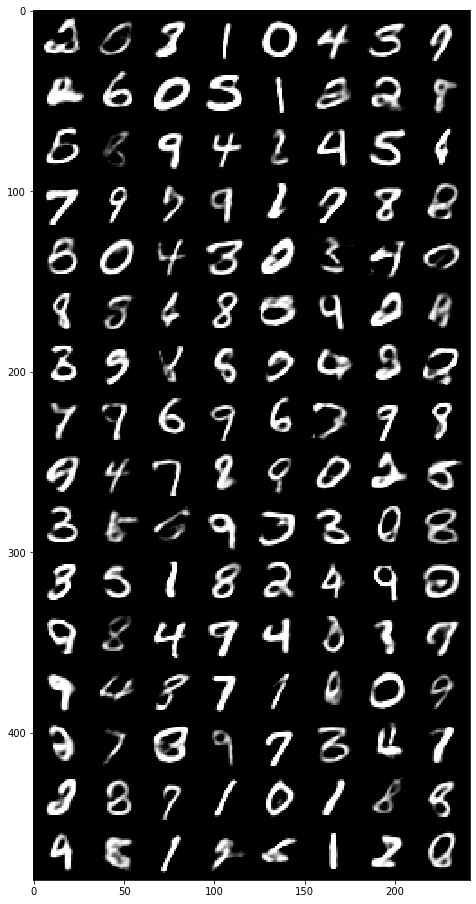

[0.79473254 0.01211735 0.00960619 0.00892857 0.00799187 0.00751355
 0.00717474 0.00674625 0.00629783 0.0070751  0.00711496 0.00681601
 0.00653699 0.0066466  0.00694555 0.00740394 0.00813138 0.00848015
 0.00912787 0.06461256] [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]


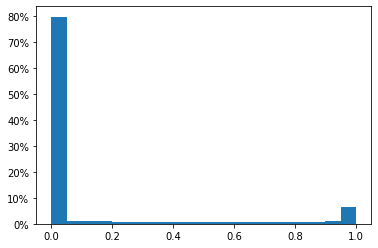

In [ ]:
plt.figure(figsize=(8, 16))

with torch.no_grad():
    z = torch.randn(128, 32).cuda()
    # print (z.shape)
    sample = vae.decoder(z).cuda()
    unwhitened = post_process_amnist(sample.view(128, 1, 28, 28))
    show(make_grid(unwhitened, normalize=False, scale_each=False))
    plt.show()
    pixel_histogram(unwhitened, num_bins=20)

Compare to MNIST test samples:

tensor(0.) tensor(1.)


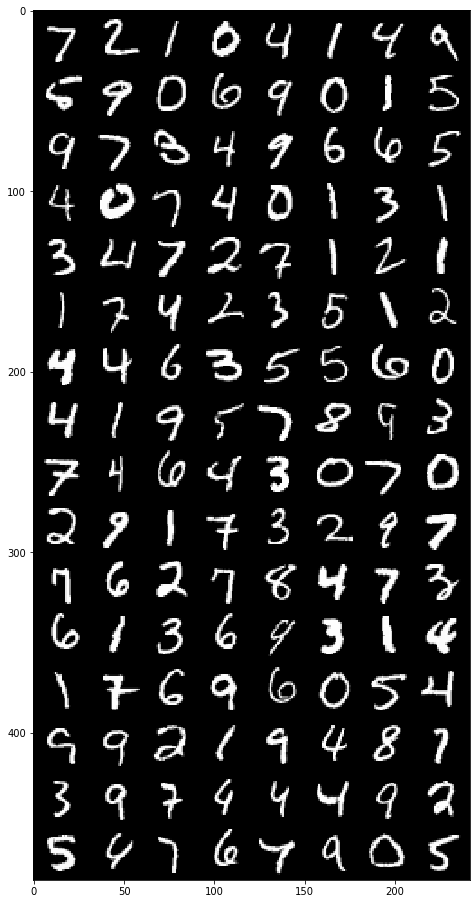

[0.83092514 0.00846022 0.00646724 0.00518176 0.0058793  0.00518176
 0.00520169 0.00443439 0.00427495 0.00443439 0.00578962 0.00445432
 0.00472337 0.00501236 0.00523158 0.0053412  0.00611846 0.00653699
 0.0085798  0.06777144] [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]


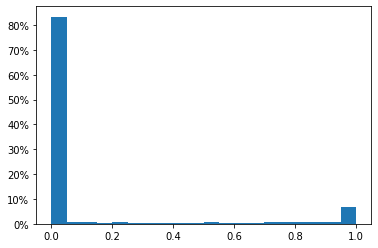

In [ ]:
plt.figure(figsize=(8, 16))
for data, _ in mnist_test_loader:
    unwhitened = unwhiten_mnist(data.view(batch_size, 1, 28, 28))
    print(unwhitened.min(), unwhitened.max())
    show(make_grid(unwhitened, normalize=False, scale_each=False))
    plt.show()
    plt.show()
    pixel_histogram(unwhitened, num_bins=20)
    break

## LeNet Ensemble for Classification

A slightly adapted version of LeNet-5 (https://ieeexplore.ieee.org/document/726791). We don't use padding, use max pooling and ReLUs.

In [ ]:
# Train a LeNet on MNIST
class LeNet(nn.Module):
    def __init__(self, num_classes):
        super(LeNet, self).__init__()
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [ ]:
def lenet_train(epoch, train_loader, optimizer, lenet):
    lenet.train()
    train_loss = 0
    for batch_idx, (data, label) in enumerate(train_loader):
        data = data.cuda()
        label = label.cuda()
        optimizer.zero_grad()

        out = lenet(data)
        loss = F.cross_entropy(out, label)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item() / len(data),
                )
            )
    print(
        "====> Epoch: {} Average loss: {:.4f}".format(
            epoch, train_loss / len(train_loader.dataset)
        )
    )


def lenet_test(test_loader, lenet):
    lenet.eval()
    test_loss = 0
    with torch.no_grad():
        for data, label in test_loader:
            data = data.cuda()
            label = label.cuda()
            out = lenet(data)

            # sum up batch loss
            test_loss += F.cross_entropy(out, label).item()

    test_loss /= len(test_loader.dataset)
    print("====> Test set loss: {:.4f}".format(test_loss))
    return test_loss

In [ ]:
lenets = []
num_ensemble_components = 5

for i in tqdm(range(num_ensemble_components)):

    @restore_or_create(f"lenet_model_{i}.model")
    def train_lenet_model():
        lenet = LeNet(num_classes=10).cuda()
        optimizer = optim.Adam(lenet.parameters())

        best_loss = None
        best_epoch = None
        for epoch in tqdm(
            range(1, 101 // num_ensemble_components)
        ):  # lenet seems to converge after about 10 epochs anyways..
            lenet_train(epoch, mnist_train_loader, optimizer, lenet)
            test_loss = lenet_test(mnist_test_loader, lenet)
            if not best_loss or best_loss > test_loss:
                torch.save(lenet.state_dict(), "./tmp_lenet_best.model")
                best_loss = test_loss
                best_epoch = epoch
                print("New best model", best_epoch, " with ", best_loss)

        print("Best epoch", best_epoch)

        lenet.load_state_dict(torch.load("./tmp_lenet_best.model"))
        return lenet

    lenets.append(train_lenet_model())

  0%|          | 0/5 [00:00<?, ?it/s]

## Calibrating the VAE

Let's calibrate the output of the VAE to match real MNIST as much as possible.

### Creating Unambiguous VAE Samples

In [ ]:
def pred_entropy(
    pre_softmaxs,
):  # shape: [MC samples from pred / ensemble, num data, classes]
    softmaxs = F.softmax(pre_softmaxs, dim=-1)
    softmax = torch.mean(softmaxs, dim=0)
    logits = torch.log(softmax)
    nats = -logits * softmax
    nats[torch.isnan(nats)] = 0.0
    return nats.sum(dim=-1)


def avg_entropy(
    pre_softmaxs,
):  # shape: [MC samples from pred / ensemble, num data, classes]
    # NOTE: looking at average ent, not pred ent
    softmax = F.softmax(pre_softmaxs, dim=-1)
    logits = F.log_softmax(pre_softmaxs, dim=-1)
    nats = -logits * softmax
    nats[torch.isnan(nats)] = 0.0
    nats = nats.sum(dim=-1)  # sum over classes
    return nats.mean(dim=0)  # average over MC samples!

In [ ]:
class_indices = [
    np.nonzero((mnist_train_dataset.targets == c).cpu().numpy())[0]
    for c in range(10)
]

In [ ]:
@restore_or_create("unambiguous_samples.pt", recreate=False)
@torch.no_grad()
def create_unambiguous_samples():
    decoded_images = []
    decoded_labels = []

    batch_size = 8192

    num_amb_examples = 60000
    num_new_samples = 0

    sample_progress = tqdm(range(num_amb_examples))

    while num_new_samples < num_amb_examples:
        z = torch.randn(batch_size, 32).cuda()
        decoded_lerps = vae.decoder(z).view(batch_size, 1, 28, 28)

        whitened_samples = whiten_mnist(decoded_lerps)
        lenet_pre_softmaxs = [
            lenet(whitened_samples.cuda()) for lenet in lenets
        ]
        lenet_pre_softmaxs = torch.stack(lenet_pre_softmaxs)

        batch_labels = (
            F.softmax(lenet_pre_softmaxs, dim=-1).mean(dim=0).argmax(dim=-1)
        )
        batch_pred_entropies = pred_entropy(lenet_pre_softmaxs)
        batch_avg_entropies = avg_entropy(lenet_pre_softmaxs)
        batch_mi = batch_pred_entropies - batch_avg_entropies
        ambiguous_samples = (batch_pred_entropies < 0.05) & (batch_mi < 0.1)

        decoded_images.append(decoded_lerps[ambiguous_samples].cpu())
        decoded_labels.append(batch_labels[ambiguous_samples].cpu())

        num_new_samples += ambiguous_samples.sum().item()

        sample_progress.update(ambiguous_samples.sum().item())

    sample_progress.close()

    decoded_images = torch.cat(decoded_images).cpu()
    decoded_labels = torch.cat(decoded_labels).cpu()
    return decoded_images, decoded_labels


(
    unambiguous_decoded_images,
    unambiguous_decoded_labels,
) = create_unambiguous_samples()

In [ ]:
unambiguous_decoded_labels.shape

torch.Size([62360])

### Creating a Histogram of (unwhitened) MNIST

Subsample the train dataset to create a balanced dataset. We will do the same for the unambiguous VAE samples, which will make the histograms more comparable.

In [ ]:
[len(ci) for ci in class_indices]

[5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]

In [ ]:
smallest_class_size = min([len(ci) for ci in class_indices])
smallest_class_size

5421

Sample 5421 elements each from each class:

In [ ]:
balanced_mnist = torch.cat(
    [
        mnist_train_loader.dataset.data[ci[:smallest_class_size]]
        for ci in class_indices
    ]
)

Show a histogram for (balanced) MNIST

[0.81640133 0.00823395 0.00682086 0.00541949 0.005625   0.0053679
 0.00519218 0.00417485 0.00499804 0.00457014 0.00604344 0.00472626
 0.00472859 0.00533143 0.00568791 0.00540999 0.00605664 0.00704276
 0.00860288 0.07956635] [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]


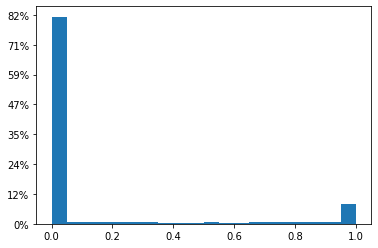

In [ ]:
num_histogram_bins = 20
pixel_histogram(balanced_mnist / 255.0, num_histogram_bins)

We see two peaks: 82% of the pixels are close to 0 and 7.9% are close to 1.

### Creating a Histogram for the Unambiguous VAE Samples

We start by visualizing the label distribution.

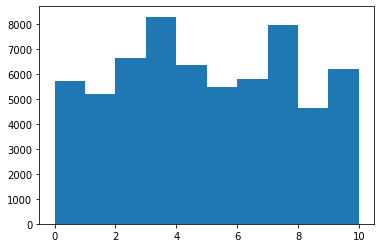

In [ ]:
vae_mnist_label_histogram = np.histogram(
    unambiguous_decoded_labels.numpy(), bins=10, range=[0, 10]
)
plt.bar(
    vae_mnist_label_histogram[1][:-1],
    vae_mnist_label_histogram[0],
    align="edge",
    width=1,
)
plt.show()

In [ ]:
smallest_class_size = min(vae_mnist_label_histogram[0])
smallest_class_size

4644

In [ ]:
balanced_vae_mnist = torch.cat(
    [
        unambiguous_decoded_images.data[unambiguous_decoded_labels == c][
            :smallest_class_size
        ]
        for c in range(10)
    ]
)

In [ ]:
balanced_vae_mnist.shape

torch.Size([46440, 1, 28, 28])

We compute and calibrate the whitened samples to match the unwhitened MNIST samples as much as possible. `calibrated_post_process_vae_mnist` unwhitens a VAE sample. To classify it with the LeNet ensemble, we will have to pass it through `whiten_mnist` again.

In [ ]:
vae_mnist_mean = torch.mean(balanced_vae_mnist)
vae_mnist_std = torch.std(balanced_vae_mnist)
print(vae_mnist_mean, vae_mnist_std)

vae_mnist_min, vae_mnist_max = (
    balanced_vae_mnist.min(),
    balanced_vae_mnist.max(),
)
print(vae_mnist_min, vae_mnist_max)

tensor(-0.0071) tensor(0.9023)
tensor(-0.4242) tensor(2.8215)


In [ ]:
def calibrated_post_process_vae_mnist(sample):
    # unwhitened = (sample - mnist_in_amnist_min) / (mnist_in_amnist_max - mnist_in_amnist_min)
    # unwhitened = torch.clamp(1.4 * unwhitened, 0, 1)**1.4
    # unwhitened = unwhiten_mnist(unwhitened)

    whitened_amnist = (sample - vae_mnist_mean) / vae_mnist_std
    unwhitened_mnist = unwhiten_mnist(whitened_amnist)
    unwhitened_mnist = torch.clamp(1.3 * unwhitened_mnist - 0.15, 0, 1)
    return unwhitened_mnist

[0.80909825 0.00862612 0.00754388 0.00680972 0.00627411 0.00588613
 0.00564301 0.00544646 0.00534355 0.00528411 0.00525178 0.0053071
 0.00541768 0.00554627 0.00574589 0.00597422 0.00633806 0.00675845
 0.00728955 0.08041564] [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]


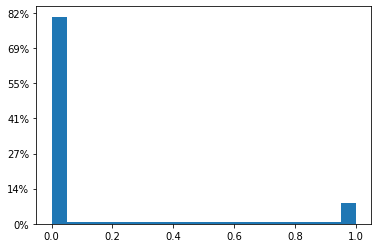

In [ ]:
# compute a histogram for VAE-MNIST
pixel_histogram(
    calibrated_post_process_vae_mnist(balanced_vae_mnist),
    num_bins=num_histogram_bins,
)

The calibrated histogram mostly matches MNIST now.

## Creating Ambiguous VAE Samples

### Sampling from the Latent Space

In [ ]:
@restore_or_create("stratified_ambiguous_samples.pt", recreate=False)
@torch.no_grad()
def create_stratified_ambiguous_samples():
    mi_threshold = 0.1
    bin_edges = [0, 0.1, 0.5, 1.0, 10.0]
    target_counts = [60000, 300000, 200000, 100000]
    num_bins = len(bin_edges) - 1
    bucket_counts = [0] * num_bins
    buckets = [[] for _ in range(num_bins)]

    assert len(target_counts) == len(bucket_counts) == len(buckets) == num_bins

    batch_size = 16384

    total_target_count = sum(target_counts)

    sample_progress = tqdm(range(total_target_count))
    while any(
        count < target for count, target in zip(bucket_counts, target_counts)
    ):
        z = torch.randn(batch_size, 32).cuda()
        decoded_lerps = vae.decoder(z).view(batch_size, 1, 28, 28)

        whitened_samples = whiten_mnist(
            calibrated_post_process_vae_mnist(decoded_lerps)
        )
        lenet_pre_softmaxs = [
            lenet(whitened_samples.cuda()) for lenet in lenets
        ]
        lenet_pre_softmaxs = torch.stack(lenet_pre_softmaxs)
        batch_pred_entropies = pred_entropy(lenet_pre_softmaxs)
        batch_avg_entropies = avg_entropy(lenet_pre_softmaxs)
        batch_mi = batch_pred_entropies - batch_avg_entropies

        id_samples = batch_mi <= mi_threshold

        for bucket_index, (count, target, bucket, lower, upper) in enumerate(
            zip(
                bucket_counts,
                target_counts,
                buckets,
                bin_edges[:-1],
                bin_edges[1:],
            )
        ):
            bucket_samples = (
                id_samples
                & (lower <= batch_pred_entropies)
                & (batch_pred_entropies < upper)
            )
            num_new_samples = bucket_samples.sum().item()

            if num_new_samples == 0 or count >= target:
                continue

            bucket.append(decoded_lerps[bucket_samples])
            bucket_counts[bucket_index] += num_new_samples
            sample_progress.update(num_new_samples)

    sample_progress.close()

    buckets = [torch.cat(bucket).cpu() for bucket in buckets if bucket]
    buckets = torch.cat(buckets)
    return buckets


stratified_ambiguous_samples = create_stratified_ambiguous_samples().cpu()

### Sampling Convex Combinations of MNIST Training Samples

In [ ]:
@restore_or_create(
    "stratified_ambiguous_samples_convex_mixture.pt", recreate=False
)
@torch.no_grad()
def create_stratified_ambiguous_mixture_samples():
    mi_threshold = 0.1
    bin_edges = [0, 0.1, 0.5, 1.0, 10.0]
    target_counts = [0, 300000, 200000, 100000]
    num_bins = len(bin_edges) - 1
    bucket_counts = [0] * num_bins
    buckets = [[] for _ in range(num_bins)]

    assert len(target_counts) == len(bucket_counts) == len(buckets) == num_bins

    total_target_count = sum(target_counts)

    num_samples_per_pair = 64

    num_label_range = list(range(2, 7))

    batch_size = 65536 // num_samples_per_pair

    sample_progress = tqdm(range(total_target_count))
    while any(
        count < target for count, target in zip(bucket_counts, target_counts)
    ):
        for num_labels in num_label_range:
            num_new_samples = 0

            batch_labels = []
            batch_data = []
            for j in range(batch_size):
                label = np.random.choice(10, num_labels, replace=False)
                batch_indices = [
                    np.random.choice(len(class_indices[c]), 1)[0] for c in label
                ]
                data = torch.stack(
                    [train_dataset[i][0] for i in batch_indices]
                ).cuda()
                label = torch.tensor(label).cuda()
                batch_labels.append(label)
                batch_data.append(data)

            batch_data = torch.stack(batch_data)
            batch_labels = torch.stack(batch_labels)

            mu, logvar = vae.encoder(batch_data.view(-1, 784))

            mix_weights = torch.rand(
                batch_size * num_samples_per_pair, num_labels + 1
            ).cuda()
            mix_weights[:, 0] = 0
            mix_weights[:, -1] = 1
            mix_weights = torch.sort(mix_weights, dim=-1)[0]
            mix_weights = mix_weights[:, 1:] - mix_weights[:, :-1]
            mixed_encodings = mix_weights.view(
                batch_size, num_samples_per_pair, num_labels
            ) @ mu.view(batch_size, num_labels, -1)
            decoded_lerps = vae.decoder(mixed_encodings).view(
                batch_size * num_samples_per_pair, 1, 28, 28
            )

            whitened_samples = whiten_mnist(
                calibrated_post_process_vae_mnist(decoded_lerps)
            )
            lenet_pre_softmaxs = [
                lenet(whitened_samples.cuda()) for lenet in lenets
            ]
            lenet_pre_softmaxs = torch.stack(lenet_pre_softmaxs)
            batch_pred_entropies = pred_entropy(lenet_pre_softmaxs)
            batch_avg_entropies = avg_entropy(lenet_pre_softmaxs)
            batch_mi = batch_pred_entropies - batch_avg_entropies

            id_samples = batch_mi <= mi_threshold

            for bucket_index, (
                count,
                target,
                bucket,
                lower,
                upper,
            ) in enumerate(
                zip(
                    bucket_counts,
                    target_counts,
                    buckets,
                    bin_edges[:-1],
                    bin_edges[1:],
                )
            ):
                bucket_samples = (
                    id_samples
                    & (lower <= batch_pred_entropies)
                    & (batch_pred_entropies < upper)
                )
                num_new_samples = bucket_samples.sum().item()

                if num_new_samples == 0 or count >= target:
                    continue

                bucket.append(decoded_lerps[bucket_samples].cpu())
                bucket_counts[bucket_index] += num_new_samples
                sample_progress.update(num_new_samples)

    sample_progress.close()

    buckets = [torch.cat(bucket).cpu() for bucket in buckets if bucket]
    buckets = torch.cat(buckets).cpu()
    return buckets


stratified_ambiguous_samples_convex_mixture = (
    create_stratified_ambiguous_mixture_samples().cpu()
)

### Comparison of Both Methods

We compute various statistics to examine the samples we have generated further.

In [ ]:
from dataclasses import dataclass


@dataclass
class SampleEvaluation:
    pred_entropies: torch.Tensor
    mutual_infos: torch.Tensor
    softmax_logits: torch.Tensor
    softmax_predictions: torch.Tensor
    predictions: torch.Tensor
    single_labels: torch.Tensor

In [ ]:
@torch.no_grad()
def evaluate_samples(samples):
    pred_entropies = []
    avg_entropies = []
    softmax_logits = []
    softmax_predictions = []
    predictions = []
    predicted_labels = []

    for decoded_image_batch in tqdm(torch.split(samples, 32768)):
        whitened_sample = whiten_mnist(
            calibrated_post_process_vae_mnist(decoded_image_batch.cuda())
        )
        lenet_pre_softmaxs = [lenet(whitened_sample) for lenet in lenets]
        lenet_pre_softmaxs = torch.stack(lenet_pre_softmaxs)

        batch_pred_entropies = pred_entropy(lenet_pre_softmaxs)
        batch_avg_entropies = avg_entropy(lenet_pre_softmaxs)

        pred_entropies.append(batch_pred_entropies.cpu())
        avg_entropies.append(batch_avg_entropies.cpu())

        lenet_pre_softmaxs = torch.transpose(
            lenet_pre_softmaxs, 0, 1
        )  # swap MC samples with batch dims
        softmax_logits.append(lenet_pre_softmaxs.cpu())

        batch_sm_pred = F.softmax(lenet_pre_softmaxs, dim=-1)
        softmax_predictions.append(batch_sm_pred.cpu())

        batch_pred = batch_sm_pred.mean(dim=1)
        predictions.append(batch_pred.cpu())

        batch_pred_labels = batch_pred.argmax(-1)
        predicted_labels.append(batch_pred_labels.cpu())

    pred_entropies = torch.cat(pred_entropies)
    avg_entropies = torch.cat(avg_entropies)
    softmax_logits = torch.cat(softmax_logits)
    softmax_predictions = torch.cat(softmax_predictions)
    predictions = torch.cat(predictions)
    predicted_labels = torch.cat(predicted_labels)

    return SampleEvaluation(
        pred_entropies,
        pred_entropies - avg_entropies,
        softmax_logits,
        softmax_predictions,
        predictions,
        predicted_labels,
    )


ambiguous_samples_evaluation = restore_or_create(
    "ambiguous_samples_evaluation.pt", recreate=False
)(lambda: evaluate_samples(stratified_ambiguous_samples))()
ambiguous_samples_evaluation_convex_mixture = restore_or_create(
    "convex_mixture_ambiguous_samples_evaluation.pt", recreate=False
)(lambda: evaluate_samples(stratified_ambiguous_samples_convex_mixture))()

### Predictive Entropy Histogram

(Note we remove samples with MI > 0.1)

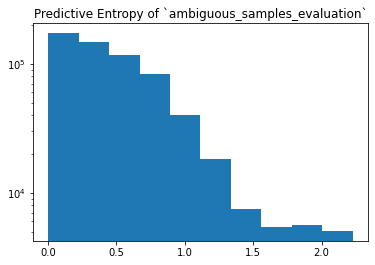

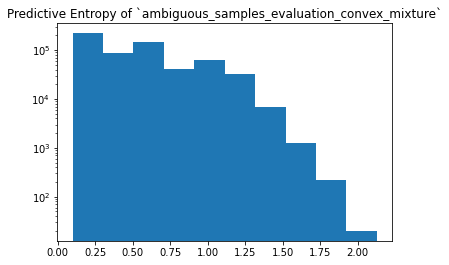

In [ ]:
plt.yscale("log")
plt.hist(ambiguous_samples_evaluation.pred_entropies.numpy(), bins=10)
plt.title("Predictive Entropy of `ambiguous_samples_evaluation`")
plt.show()

plt.yscale("log")
plt.hist(
    ambiguous_samples_evaluation_convex_mixture.pred_entropies.numpy(), bins=10
)
plt.title("Predictive Entropy of `ambiguous_samples_evaluation_convex_mixture`")
plt.show()

#### Example Samples

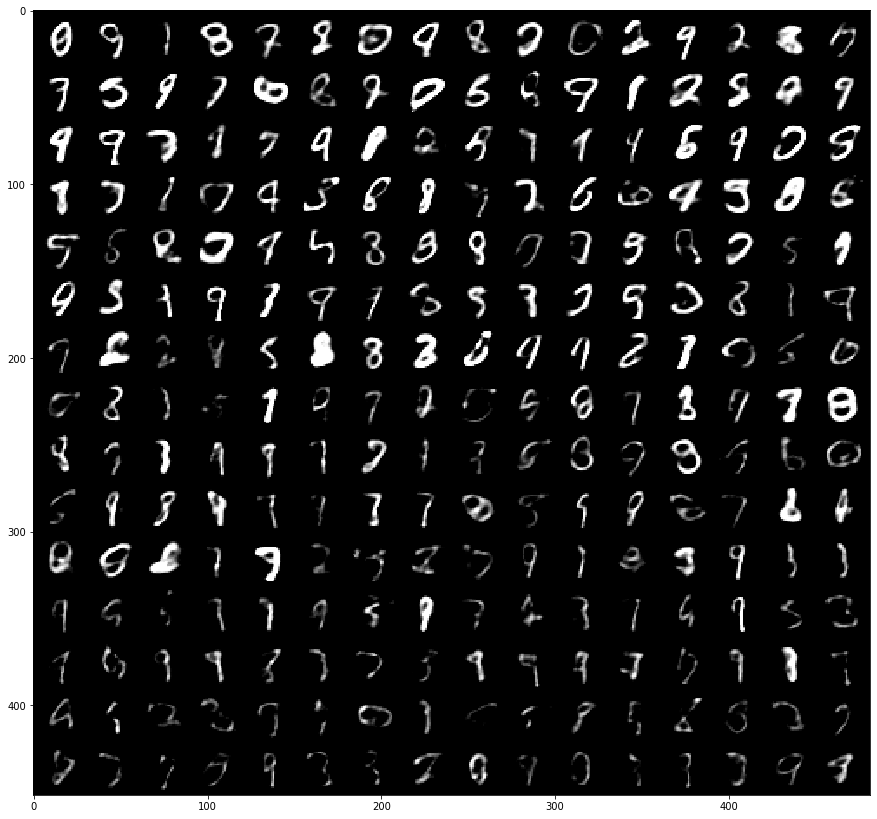

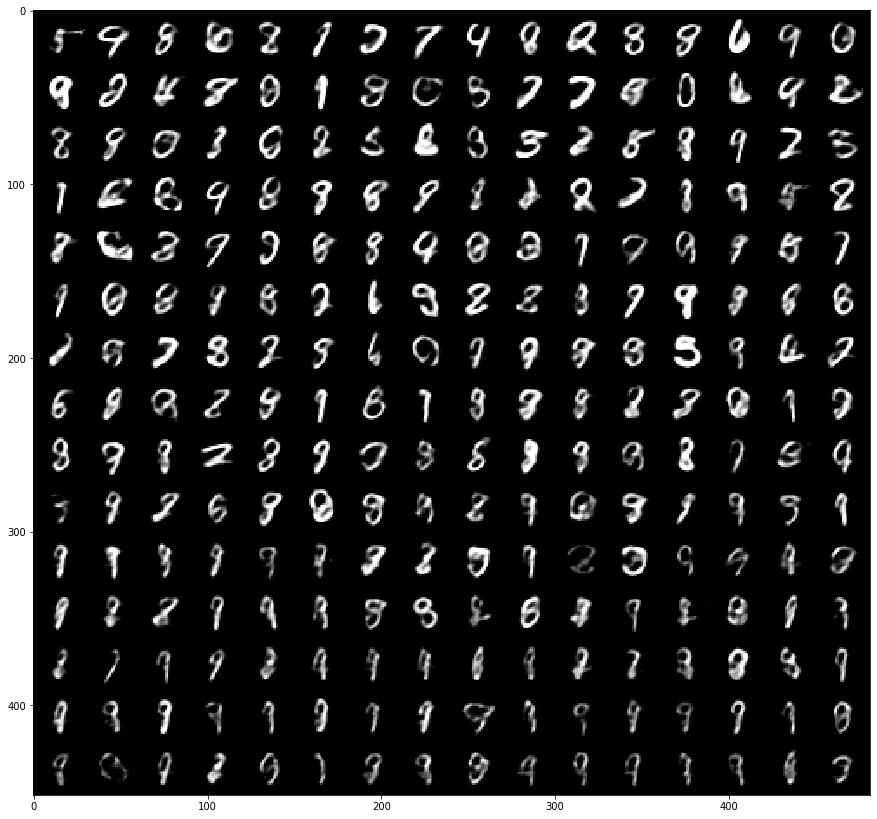

In [ ]:
def show_stratified_samples(
    samples, pred_entropies, num_pe_bins, num_bin_samples, range=None
):
    stratified_samples = []
    edges = np.histogram_bin_edges(
        pred_entropies, bins=num_pe_bins, range=range
    )
    for lower, upper in zip(edges[:-1], edges[1:]):
        bucket_mask = (pred_entropies >= lower) & (pred_entropies < upper)
        bucket_samples = samples[bucket_mask]
        sample_indices = np.random.choice(
            len(bucket_samples), size=num_bin_samples, replace=False
        )
        row_samples = bucket_samples[sample_indices]
        stratified_samples.append(row_samples)

    stratified_samples = torch.cat(stratified_samples)
    plt.figure(figsize=(num_pe_bins, num_bin_samples))
    show(
        make_grid(
            calibrated_post_process_vae_mnist(
                stratified_samples.view(-1, 1, 28, 28)
            ),
            normalize=False,
            nrow=num_bin_samples,
        )
    )
    plt.show()


show_stratified_samples(
    stratified_ambiguous_samples,
    ambiguous_samples_evaluation.pred_entropies,
    15,
    16,
    range=[0.1, 1.6],
)
show_stratified_samples(
    stratified_ambiguous_samples_convex_mixture,
    ambiguous_samples_evaluation_convex_mixture.pred_entropies,
    15,
    16,
    range=[0.1, 1.6],
)

The convex mixture samples look much better overall. However, we have to limit the entropy range to `[0.1, 1.6]` as there are not sufficiently many samples beyond that:

(array([336., 172.,  88.,  75.,  30.,   6.,   2.,   1.,   0.,   0.]),
 array([1.6 , 1.67, 1.74, 1.81, 1.88, 1.95, 2.02, 2.09, 2.16, 2.23, 2.3 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

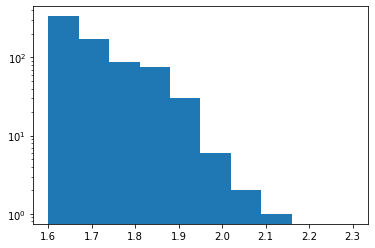

In [ ]:
plt.yscale("log")
plt.hist(
    ambiguous_samples_evaluation_convex_mixture.pred_entropies.numpy(),
    bins=10,
    range=[1.6, 2.3],
)

(array([25490., 22922., 20823., 19069., 17818., 16650., 15735., 15232.,
        14399., 13292., 12522., 11731., 10894., 10105.,  9425.,  8529.,
         8085.,  7371.,  6834.,  6234.,  5754.,  5120.,  4801.,  4446.,
         4013.,  3580.,  8031., 17615., 15957., 14625., 13232., 12308.,
        11091., 10362.,  9701.,  8804.,  8299.,  7838.,  7434.,  7945.,
         6911.,  5758.,  5062.,  4196.,  3903.,  3390.,  2966.,  2552.,
         2220.,  1973.,  1780.,  1594.,  1428.,  1264.,  1063.,   996.,
          906.,   855.,   713.,   679., 10689.,  9771.,  8695.,  7671.,
         6952.,  6279.,  5875.,  5082.,  4517.,  3876.,  3440.,  3050.,
         2623.,  2392.,  2107.,  1811.,  1705.,  1425.,  1313.,  1147.,
         1059.,  1045.,   783.,   743.,   625.,   637.,   543.,   480.,
          428.,   377.,   355.,   287.,   287.,   227.,   240.,   189.,
          161.,   169.,   109.,   111.]),
 array([0.1  , 0.115, 0.13 , 0.145, 0.16 , 0.175, 0.19 , 0.205, 0.22 ,
        0.235, 0.25 , 0

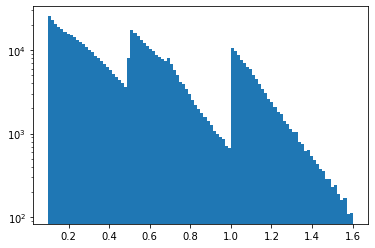

In [ ]:
plt.yscale("log")
plt.hist(
    ambiguous_samples_evaluation_convex_mixture.pred_entropies.numpy(),
    bins=100,
    range=[0.1, 1.6],
)

#### Label vs Entropy Distribution

We can look at the distribution of the labels (the most likely label). We see that the created samples are highly imbalanced.

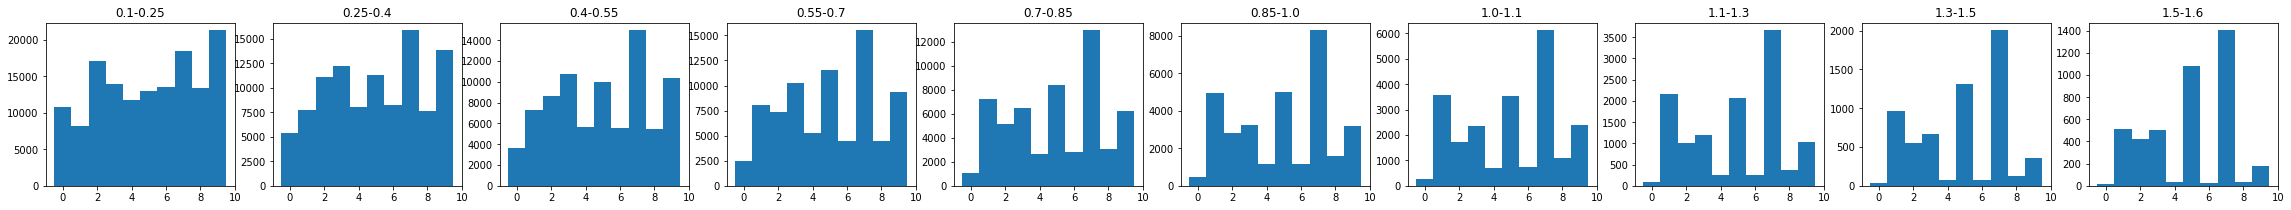

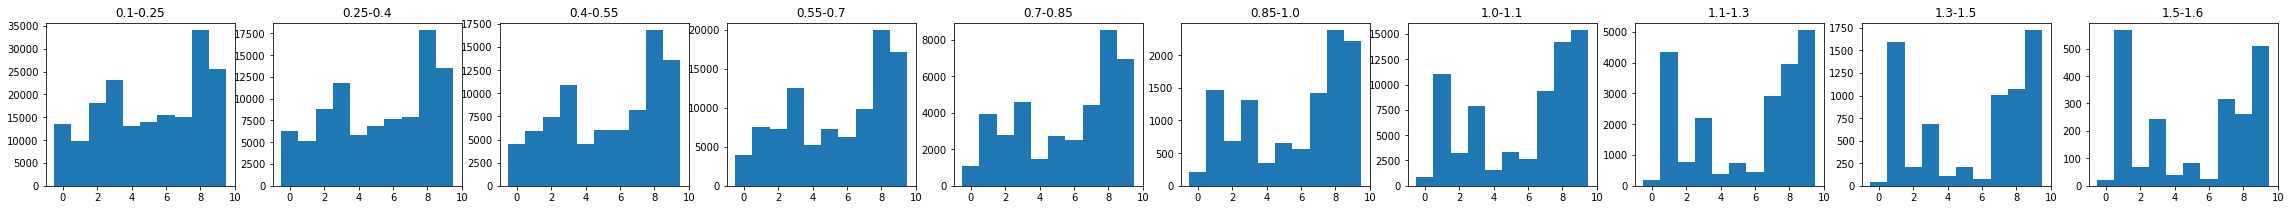

In [ ]:
def show_label_buckets(entropies, labels, num_bins, range=None):
    edges = np.histogram_bin_edges(
        entropies.numpy(), bins=num_bins, range=range
    )

    plt.figure(figsize=(num_bins * 4, 3))
    for i, (lower, upper) in enumerate(zip(edges[:-1], edges[1:])):
        plt.subplot(1, num_bins, i + 1)
        bucket_labels = labels[(lower <= entropies) & (entropies < upper)]
        # plt.yscale("log")
        plt.title(f"{lower:.2}-{upper:.2}")
        plt.hist(bucket_labels.numpy(), bins=10, range=[-0.5, 9.5])

    plt.show()


show_label_buckets(
    ambiguous_samples_evaluation.pred_entropies,
    ambiguous_samples_evaluation.single_labels,
    10,
    range=[0.1, 1.6],
)
show_label_buckets(
    ambiguous_samples_evaluation_convex_mixture.pred_entropies,
    ambiguous_samples_evaluation_convex_mixture.single_labels,
    10,
    range=[0.1, 1.6],
)

### Class Probability vs Entropy
We can also look at the distribution of class probability vs entropy:

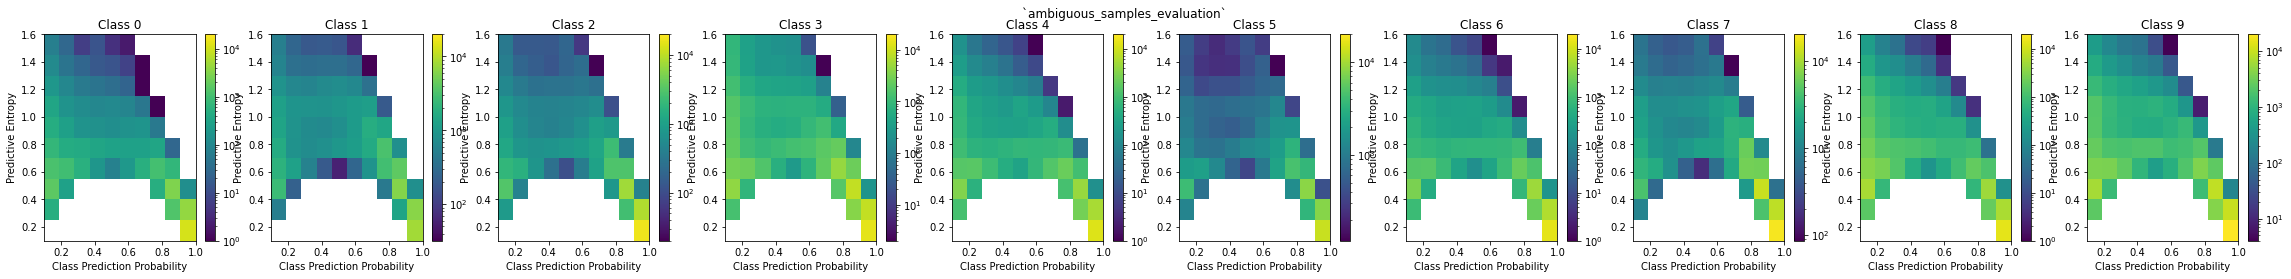

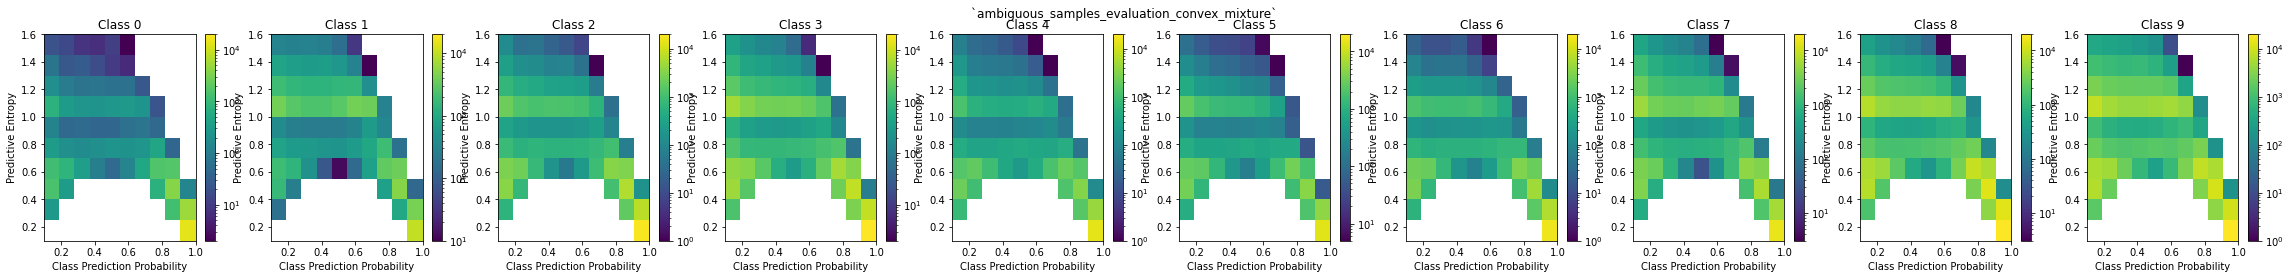

In [ ]:
import matplotlib as mpl


def show_probs_vs_entropy(
    evaluation: SampleEvaluation, num_bins, entropy_range=None
):
    entropies = evaluation.pred_entropies
    predictions = evaluation.predictions

    plt.figure(figsize=(num_bins * 4, 3.8))
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        h = plt.hist2d(
            predictions[:, i].numpy(),
            entropies.numpy(),
            bins=num_bins,
            norm=mpl.colors.LogNorm(vmax=2e4),
            range=[[0.1, 1], entropy_range],
        )
        plt.xlabel("Class Prediction Probability")
        plt.ylabel("Predictive Entropy")
        plt.title(f"Class {i}")
        ax = plt.gca()
        plt.colorbar(h[-1], use_gridspec=True, ax=ax)


show_probs_vs_entropy(
    ambiguous_samples_evaluation, 10, entropy_range=[0.1, 1.6]
)
plt.suptitle("`ambiguous_samples_evaluation`")
show_probs_vs_entropy(
    ambiguous_samples_evaluation_convex_mixture, 10, entropy_range=[0.1, 1.6]
)
plt.suptitle("`ambiguous_samples_evaluation_convex_mixture`")
plt.show()

## Balancing the Stratified Samples: Creating Ambiguous-MNIST

Ideally, we want samples that are balanced between classes.

What does that mean for ambiguous samples though?

We define a subset of samples to be balanced when the overal probability mass assinged to all classes is uniform. I.e. $\frac{1}{N} \sum_i p(y=c|x_i) \approx \frac{1}{C}$, where $N$ is the number of samples, and $C$ is the number of classes.

To balance the stratified samples, we want to balance the samples within different ranges of aleatoric uncertianty/entropy.

We examine two approaches to achieve this. The first is fully stochastic and samples random subsets, selecting the one with the highest entropy (being closest to uniform).
The second approach samples stochastically but aiming towards creating a uniform class distribution, while slowly annealing a temperature parameter.

We use the second approach.

To collect, 80k samples, we need 16k samples that we can then draw multiple labels from if we draw 5 labels per sample. This means about 1600 samples per bucket, assuming 10 buckets.

In [ ]:
def entropy(p):
    nats = -p * torch.log(p)
    nats[torch.isnan(nats)] = 0.0
    entropy = torch.sum(nats, dim=-1)
    return entropy

In [ ]:
def kl(p, q):
    items = -p * (torch.log(q) - torch.log(p))
    items[torch.isnan(items)] = 0.0
    kl = torch.sum(items, dim=-1)
    return kl

In [ ]:
def show_prob_buckets(entropies, predictions, num_bins, entropy_range=None):
    edges = np.histogram_bin_edges(
        entropies.numpy(), bins=num_bins, range=entropy_range
    )

    plt.figure(figsize=(num_bins * 4, 3))
    for i, (lower, upper) in enumerate(zip(edges[:-1], edges[1:])):
        plt.subplot(1, num_bins, i + 1)
        bucket_prob_distribution = predictions[
            (lower <= entropies) & (entropies < upper)
        ].mean(dim=0)
        print(entropy(bucket_prob_distribution))
        # plt.yscale("log")
        plt.title(f"{lower:.2}-{upper:.2}")
        plt.ylim(0, 0.3)
        plt.bar(range(10), bucket_prob_distribution.numpy(), width=1)

    plt.show()

### Fully Stochastic Balancing

  0%|          | 0/10 [00:00<?, ?it/s]

Sampling 1600 out of 2135


  0%|          | 0/2716 [00:00<?, ?it/s]

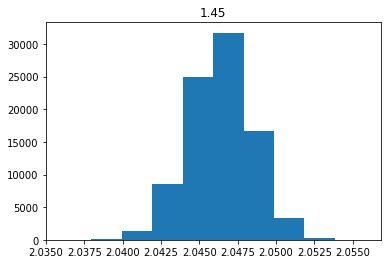

tensor(2.0558)
Sampling 1600 out of 6720


  0%|          | 0/863 [00:00<?, ?it/s]

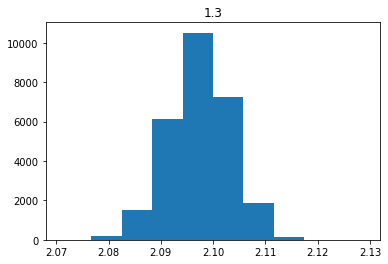

tensor(2.1291)
Sampling 1600 out of 21013


  0%|          | 0/276 [00:00<?, ?it/s]

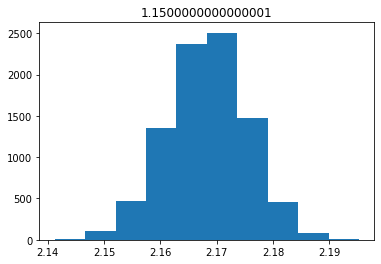

tensor(2.1952)
Sampling 1600 out of 69407


  0%|          | 0/83 [00:00<?, ?it/s]

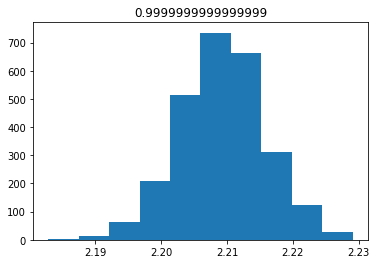

tensor(2.2291)
Sampling 1600 out of 11278


  0%|          | 0/514 [00:00<?, ?it/s]

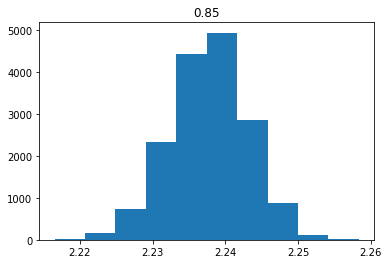

tensor(2.2584)
Sampling 1600 out of 38931


  0%|          | 0/148 [00:00<?, ?it/s]

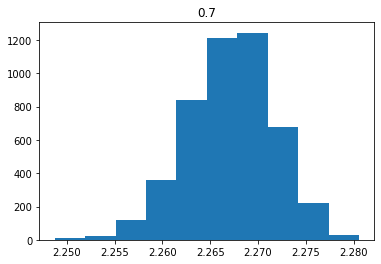

tensor(2.2806)
Sampling 1600 out of 97014


  0%|          | 0/59 [00:00<?, ?it/s]

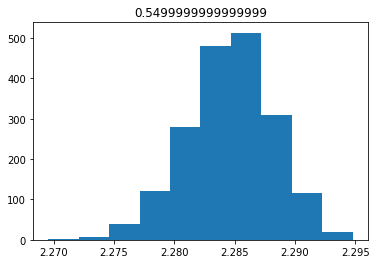

tensor(2.2948)
Sampling 1600 out of 83942


  0%|          | 0/69 [00:00<?, ?it/s]

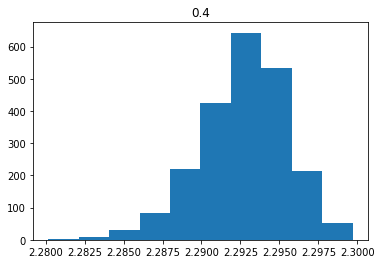

tensor(2.2997)
Sampling 1600 out of 91730


  0%|          | 0/63 [00:00<?, ?it/s]

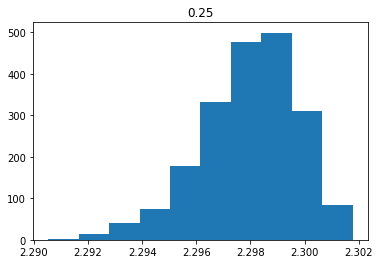

tensor(2.3018)
Sampling 1600 out of 181430


  0%|          | 0/31 [00:00<?, ?it/s]

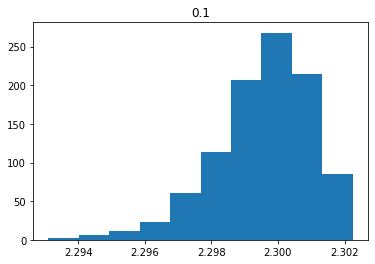

tensor(2.3022)
16000


In [ ]:
@restore_or_create("fully_stochastic_balanced_indices", recreate=False)
def fully_stochastic_balancing():
    max_samples = int(80e3)

    entropies = ambiguous_samples_evaluation_convex_mixture.pred_entropies
    predictions = ambiguous_samples_evaluation_convex_mixture.predictions

    num_bins = 10
    num_labels = 5
    edges = np.histogram_bin_edges([], bins=num_bins, range=[0.1, 1.6])

    num_stochastic_batches = 1024

    balanced_indices = []

    for lower, upper in tqdm(
        reversed(list(zip(edges[:-1], edges[1:]))), total=10
    ):
        num_bucket_samples = max_samples // num_bins // num_labels
        prob_masses = torch.zeros(10)

        bucket_mask = (lower <= entropies) & (entropies < upper)
        bucket_indices = torch.nonzero(bucket_mask, as_tuple=False)[:, 0]

        bucket_stochastic_batches = (
            num_stochastic_batches * 181243 // len(bucket_indices)
        )

        # plt.hist(entropies[bucket_indices].numpy(), bins=10, range=[0.1, 1.6])

        print(f"Sampling {num_bucket_samples} out of {len(bucket_indices)}")

        bucket_predictions = predictions[bucket_indices]
        bucket_avg_distribution = bucket_predictions.mean(dim=0)

        bucket_mean_dist = (
            bucket_predictions + bucket_avg_distribution[None, :]
        ) / 2

        bucket_weights = torch.exp(
            kl(bucket_predictions, bucket_avg_distribution)
        )

        batch_indices = torch.cat(
            [
                torch.as_tensor(
                    torch.multinomial(
                        bucket_weights.expand(32, len(bucket_indices)),
                        num_samples=num_bucket_samples,
                        replacement=False,
                    )
                )
                for _ in tqdm(range(bucket_stochastic_batches // 32))
            ]
        )
        # batch_indices = torch.multinomial(torch.ones((1, 1)).expand(num_stochastic_batches, len(bucket_indices)), num_samples=num_bucket_samples, replacement=False)

        bucket_stochastic_batches = batch_indices.shape[0]

        batch_indices_BNC = batch_indices.unsqueeze(2).expand(
            (bucket_stochastic_batches, num_bucket_samples, 10)
        )
        predictions_BNC = bucket_predictions.unsqueeze(0).expand(
            (bucket_stochastic_batches, -1, 10)
        )

        batch_prob_mass = torch.gather(
            predictions_BNC, index=batch_indices_BNC, dim=1
        ).mean(dim=1)
        batch_entropy = entropy(batch_prob_mass)

        plt.title(lower)
        plt.hist(batch_entropy.numpy(), bins=10)
        plt.show()

        best_batch_entropy, best_batch = batch_entropy.max(dim=0)
        best_batch_indices = batch_indices[best_batch]

        print(best_batch_entropy)

        balanced_indices.append(bucket_indices[best_batch_indices])

    balanced_indices = torch.cat(balanced_indices)
    print(len(balanced_indices))
    return balanced_indices


fully_stochastic_balanced_indices = fully_stochastic_balancing()

tensor(2.3022)
tensor(2.3018)
tensor(2.2997)
tensor(2.2948)
tensor(2.2806)
tensor(2.2584)
tensor(2.2291)
tensor(2.1952)
tensor(2.1291)
tensor(2.0558)


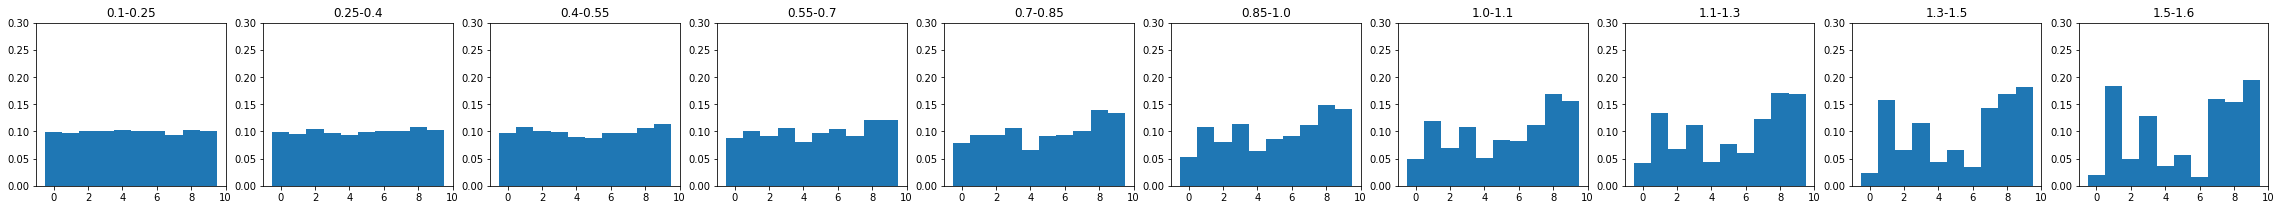

In [ ]:
show_prob_buckets(
    ambiguous_samples_evaluation_convex_mixture.pred_entropies[
        fully_stochastic_balanced_indices
    ],
    ambiguous_samples_evaluation_convex_mixture.predictions[
        fully_stochastic_balanced_indices
    ],
    10,
    entropy_range=[0.1, 1.6],
)

This does not look for higher entropy buckets.

### Annealing Stochastic Balancing

We start with an empty set in each bucket.

We pick a sample depending on how much it helps us achieve a uniform distribution.

The KL between the bucket's overal probability distribution and a uniform distribution measures how close it is to a uniform distribution:
$$ D_{KL}(p||U) = H(p||U) - H(p) = H(U) - H(p).$$
where $p$ is the distribution after adding the distribution of the sample under consideration:

$$p_\text{new}(p') = \frac{N p_\text{current} + p'}{N+1}$$

We can draw samples from $p' \sim \exp (-D_{KL}(p_\text{new}(p')||U)/\tau)$. Both together:

\begin{align}
D_{KL}(p_\text{total}(p')||U) &= H(U) - H(p_\text{new}(p'))
\end{align}

We anneal $\tau \to 0$ during training to pick the optimal samples later on.

In [ ]:
@restore_or_create("doubly_stratified_indices.pt", recreate=True)
def bucket_stratify_indices():
    max_samples = int(80e3)

    entropies = ambiguous_samples_evaluation_convex_mixture.pred_entropies
    predictions = ambiguous_samples_evaluation_convex_mixture.predictions

    num_bins = 10
    num_labels = 10

    stratified_indices = []

    gammas = [1.1, 1.3, 1.3, 1.4, 1.4, 1.4, 1.4, 1.4, 1.7, 2]

    edges = np.histogram_bin_edges([], bins=num_bins, range=[0.1, 1.6])
    for lower, upper, gamma in tqdm(
        reversed(list(zip(edges[:-1], edges[1:], gammas))), total=10
    ):
        num_bucket_samples = max_samples // num_bins // num_labels
        prob_masses = torch.zeros(10)

        bucket_mask = (lower <= entropies) & (entropies < upper)
        if stratified_indices:
            bucket_mask[torch.cat(stratified_indices)] = False
        bucket_indices = torch.nonzero(bucket_mask, as_tuple=False)[:, 0]

        print(f"Sampling {num_bucket_samples} out of {len(bucket_indices)}")

        bucket_predictions = predictions[bucket_indices]

        batch_indices = []
        batch_candidates = list(range(len(bucket_indices)))

        for batch_size in tqdm(list(range(num_bucket_samples))):
            batch_sum_prediction = (
                bucket_predictions[batch_indices].sum(dim=0).double()
            )

            candidate_avg_predictions = (
                batch_sum_prediction + bucket_predictions[batch_candidates]
            ) / (batch_size + 1)
            candidate_scores = np.log(10) - entropy(candidate_avg_predictions)

            tau = 1 / (batch_size + 1) ** gamma
            if tau > 1e-3:
                candidate_weights = torch.exp(-candidate_scores / tau)
                try:
                    index = torch.multinomial(
                        candidate_weights, num_samples=1, replacement=False
                    )
                except:
                    print(tau)
                    raise
            else:
                index = candidate_scores.argmin()

            winner = batch_candidates[index]
            winner_score = candidate_scores[index]
            batch_indices.append(winner)
            batch_candidates.remove(winner)

        print(np.log(10) - winner_score)

        stratified_indices.append(bucket_indices[batch_indices])

    stratified_indices = torch.cat(stratified_indices)
    print(len(stratified_indices))
    return stratified_indices


balanced_indices = bucket_stratify_indices()

  0%|          | 0/10 [00:00<?, ?it/s]

Sampling 800 out of 2135


  0%|          | 0/800 [00:00<?, ?it/s]

tensor(2.2090, dtype=torch.float64)
Sampling 800 out of 6720


  0%|          | 0/800 [00:00<?, ?it/s]

tensor(2.2937, dtype=torch.float64)
Sampling 800 out of 21013


  0%|          | 0/800 [00:00<?, ?it/s]

tensor(2.3026, dtype=torch.float64)
Sampling 800 out of 69407


  0%|          | 0/800 [00:00<?, ?it/s]

tensor(2.3026, dtype=torch.float64)
Sampling 800 out of 11278


  0%|          | 0/800 [00:00<?, ?it/s]

tensor(2.3026, dtype=torch.float64)
Sampling 800 out of 38931


  0%|          | 0/800 [00:00<?, ?it/s]

tensor(2.3026, dtype=torch.float64)
Sampling 800 out of 97014


  0%|          | 0/800 [00:00<?, ?it/s]

tensor(2.3026, dtype=torch.float64)
Sampling 800 out of 83942


  0%|          | 0/800 [00:00<?, ?it/s]

tensor(2.3026, dtype=torch.float64)
Sampling 800 out of 91730


  0%|          | 0/800 [00:00<?, ?it/s]

tensor(2.3026, dtype=torch.float64)
Sampling 800 out of 181430


  0%|          | 0/800 [00:00<?, ?it/s]

tensor(2.3026, dtype=torch.float64)
8000


(array([400., 400., 400., 400., 400., 400., 400., 400., 400., 400.]),
 array([0.1 , 0.25, 0.4 , 0.55, 0.7 , 0.85, 1.  , 1.15, 1.3 , 1.45, 1.6 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

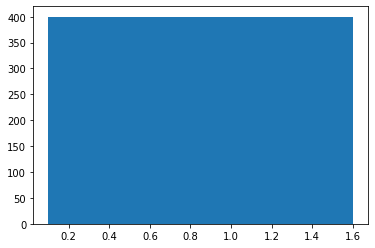

In [ ]:
plt.hist(
    ambiguous_samples_evaluation_convex_mixture.pred_entropies[
        balanced_indices
    ].numpy(),
    bins=10,
    range=[0.1, 1.6],
)

### Balanced Distribution per Entropy Bucket

tensor(2.3026)
tensor(2.3026)
tensor(2.3026)
tensor(2.3026)
tensor(2.3026)
tensor(2.3026)
tensor(2.3026)
tensor(2.3026)
tensor(2.2937)
tensor(2.2090)


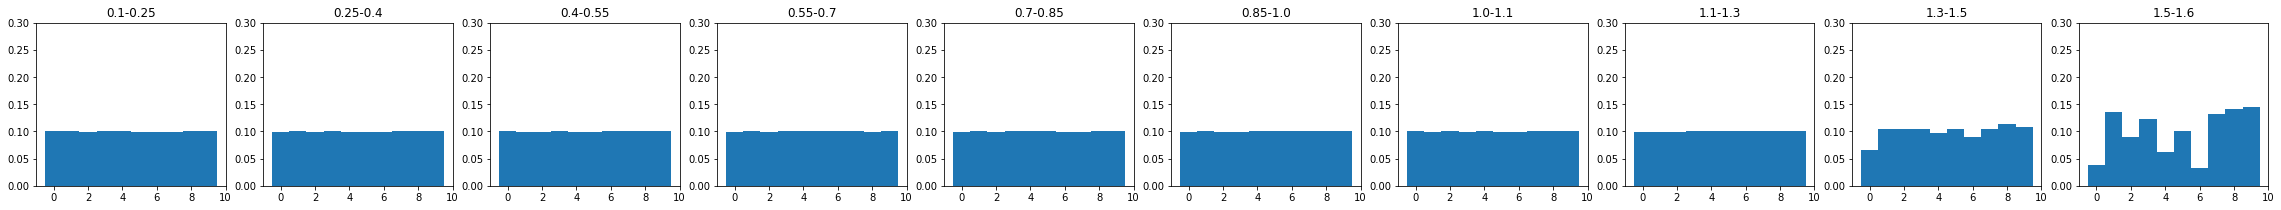

In [ ]:
show_prob_buckets(
    ambiguous_samples_evaluation_convex_mixture.pred_entropies[
        balanced_indices
    ],
    ambiguous_samples_evaluation_convex_mixture.predictions[balanced_indices],
    10,
    entropy_range=[0.1, 1.6],
)

#### Original Stratified Distribution

tensor(2.2339)
tensor(2.2215)
tensor(2.2035)
tensor(2.1821)
tensor(2.1558)
tensor(2.1155)
tensor(2.0613)
tensor(2.0047)
tensor(1.9769)
tensor(2.0120)


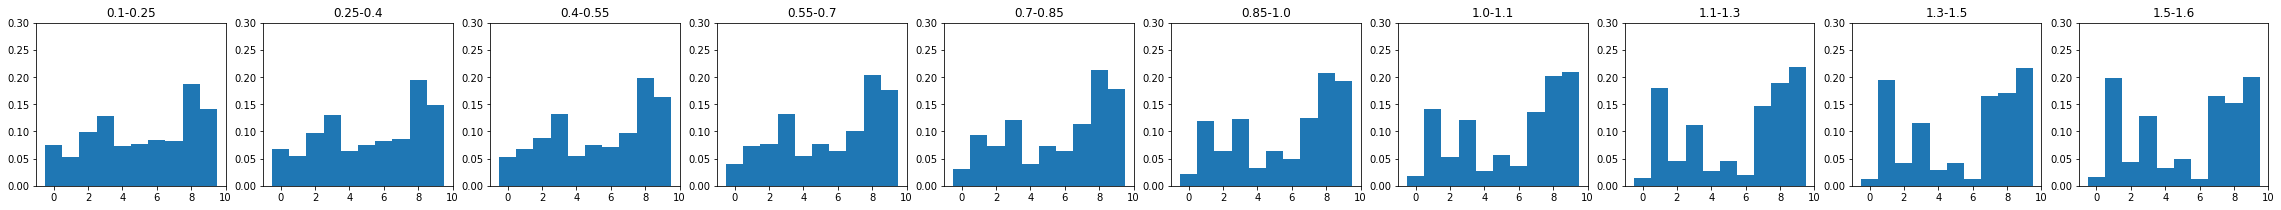

In [ ]:
show_prob_buckets(
    ambiguous_samples_evaluation_convex_mixture.pred_entropies,
    ambiguous_samples_evaluation_convex_mixture.predictions,
    10,
    entropy_range=[0.1, 1.6],
)

### Visualize Balanced & Stratified Samples

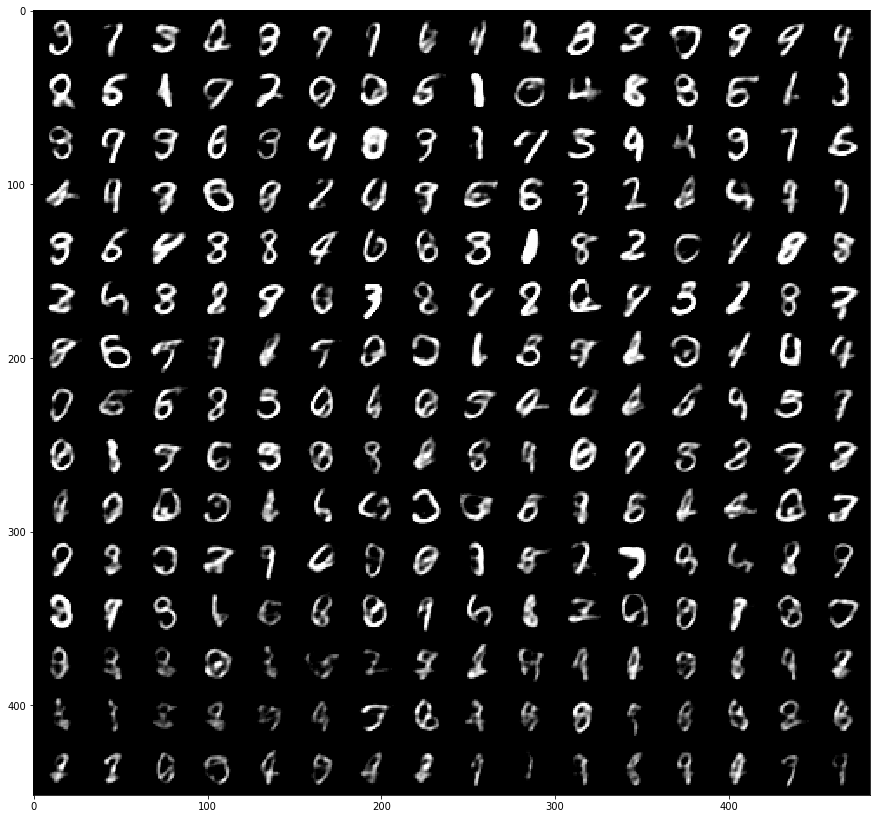

In [ ]:
show_stratified_samples(
    stratified_ambiguous_samples_convex_mixture[balanced_indices],
    ambiguous_samples_evaluation_convex_mixture.pred_entropies[
        balanced_indices
    ],
    15,
    16,
    range=[0.1, 1.6],
)

### Generating Labels for Ambiguous-MNIST

We will draw 10 labels for each sample. First we will shuffle the balanced indices though.

In [ ]:
shuffled_balanced_amnist_indices = balanced_indices[
    torch.randperm(len(balanced_indices))
]

In [ ]:
amnist_predictions = ambiguous_samples_evaluation_convex_mixture.predictions[
    shuffled_balanced_amnist_indices
]

In [ ]:
def draw_labels(predictions, num_labels):
    drawn_labels = torch.multinomial(
        predictions, num_samples=num_labels, replacement=True
    )
    return drawn_labels

In [ ]:
@restore_or_create("internal_amnist_labels.pt", recreate=False)
def create_amnist_labels():
    amnist_labels = draw_labels(amnist_predictions, 10)
    return amnist_labels


amnist_labels = create_amnist_labels()

In [ ]:
amnist_samples = stratified_ambiguous_samples_convex_mixture[
    shuffled_balanced_amnist_indices
]
amnist_calibrated_samples = calibrated_post_process_vae_mnist(amnist_samples)

In [ ]:
torch.save(amnist_predictions, "amnist_predictions.pt")
torch.save(amnist_labels, "amnist_labels.pt")
torch.save(amnist_samples, "amnist_raw_samples.pt")
torch.save(amnist_calibrated_samples, "amnist_samples.pt")

## Evaluating DirtyMNIST and AMNIST

### Setup Datasets and DataLoaders

In [ ]:
amnist_samples = (
    torch.load("amnist_samples.pt")
    .expand(-1, 10, 28, 28)
    .reshape(-1, 1, 28, 28)
)
amnist_labels = torch.load("amnist_labels.pt").reshape(-1)
amnist_samples.shape, amnist_labels.shape

(torch.Size([80000, 1, 28, 28]), torch.Size([80000]))

In [ ]:
amnist_whitened_samples = whiten_mnist(amnist_samples)

In [ ]:
amnist_train_dataset = torch.utils.data.TensorDataset(
    amnist_whitened_samples[:-30000], amnist_labels[:-30000]
)
amnist_test_dataset = torch.utils.data.TensorDataset(
    amnist_whitened_samples[-30000:], amnist_labels[-30000:]
)

In [ ]:
# MNIST is weird and use numpy labels, which messes up the DataLoaders
amnist_train_dataset.tensors = (
    amnist_train_dataset.tensors[0],
    amnist_train_dataset.tensors[1].numpy(),
)
amnist_test_dataset.tensors = (
    amnist_test_dataset.tensors[0],
    amnist_test_dataset.tensors[1].numpy(),
)

In [ ]:
amnist_train_loader = torch.utils.data.DataLoader(
    dataset=amnist_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=torch.cuda.is_available(),
)
amnist_test_loader = torch.utils.data.DataLoader(
    dataset=amnist_test_dataset,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=torch.cuda.is_available(),
)

In [ ]:
dmnist_train_dataset = torch.utils.data.ConcatDataset(
    [mnist_train_dataset, amnist_train_dataset]
)
dmnist_test_dataset = torch.utils.data.ConcatDataset(
    [mnist_test_dataset, amnist_test_dataset]
)

In [ ]:
dmnist_train_loader = torch.utils.data.DataLoader(
    dataset=dmnist_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=torch.cuda.is_available(),
)
dmnist_test_loader = torch.utils.data.DataLoader(
    dataset=dmnist_test_dataset,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=torch.cuda.is_available(),
)

In [ ]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            (0.1307,),
            (0.3081,),
        ),
    ]
)


fmnist_train_dataset = datasets.FashionMNIST(
    root="./fmnist_data/",
    train=True,
    download=True,
    transform=transform,
)

fmnist_test_dataset = datasets.FashionMNIST(
    root="./fmnist_data/",
    train=False,
    download=True,
    transform=transform,
)

fmnist_train_loader = torch.utils.data.DataLoader(
    fmnist_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=torch.cuda.is_available(),
)

fmnist_test_loader = torch.utils.data.DataLoader(
    fmnist_test_dataset,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=torch.cuda.is_available(),
)

### Training a LeNet Ensemble on DMNIST

In [ ]:
dmnist_lenets = []
num_ensemble_components = 5

for i in tqdm(range(num_ensemble_components)):

    @restore_or_create(f"dmnist_lenet_model_{i}.model", recreate=False)
    def train_lenet_model():
        lenet = LeNet(num_classes=10).cuda()
        optimizer = optim.Adam(lenet.parameters())

        best_loss = None
        best_epoch = None
        for epoch in tqdm(
            range(1, 101 // num_ensemble_components)
        ):  # lenet seems to converge after about 10 epochs anyways..
            lenet_train(epoch, dmnist_train_loader, optimizer, lenet)
            test_loss = lenet_test(mnist_test_loader, lenet)
            if not best_loss or best_loss > test_loss:
                torch.save(lenet.state_dict(), "./tmp_lenet_best.model")
                best_loss = test_loss
                best_epoch = epoch
                print("New best model", best_epoch, " with ", best_loss)

        print("Best epoch", best_epoch)

        lenet.load_state_dict(torch.load("./tmp_lenet_best.model"))
        return lenet

    dmnist_lenets.append(train_lenet_model())

  0%|          | 0/5 [00:00<?, ?it/s]

### Evaluating the DMNIST LeNet Ensemble

In [ ]:
@dataclass
class Evaluation:
    predictions: torch.Tensor
    entropies: torch.Tensor
    labels: torch.Tensor

In [ ]:
@torch.no_grad()
def evaluate(test_loader, lenets):
    for lenet in lenets:
        lenet.eval()

    labels = []
    predictions = []
    with torch.no_grad():
        for data, label in tqdm(test_loader):
            data = data.cuda()
            label = label.cuda()

            batch_outputs = [lenet(data.cuda()) for lenet in lenets]
            batch_outputs = torch.stack(batch_outputs)
            batch_predictions = F.softmax(batch_outputs.mean(dim=0), dim=-1)
            predictions.append(batch_predictions)
            labels.append(label)

    labels = torch.cat(labels).cpu()
    predictions = torch.cat(predictions).cpu()
    entropies = entropy(predictions).cpu()
    return Evaluation(predictions, entropies, labels)

In [ ]:
dmnist_test_evaluation = evaluate(dmnist_test_loader, dmnist_lenets[:1])
amnist_test_evaluation = evaluate(amnist_test_loader, dmnist_lenets[:1])
mnist_test_evaluation = evaluate(mnist_test_loader, dmnist_lenets[:1])
fmnist_test_evaluation = evaluate(fmnist_test_loader, dmnist_lenets[:1])

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

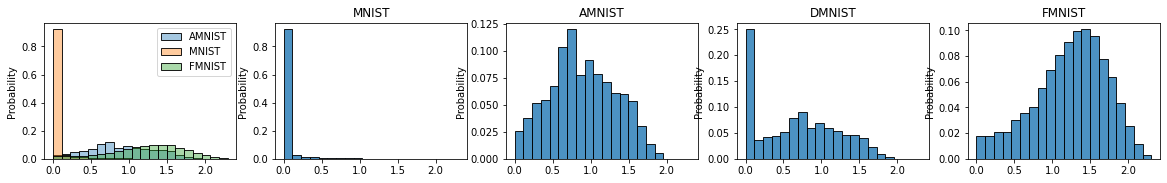

In [ ]:
import seaborn as sns


def plot_entropies(evaluation: Evaluation, **kwargs):
    sns.histplot(
        evaluation.entropies.numpy(),
        stat="probability",
        binrange=[0, np.log(10)],
        bins=20,
        **kwargs
    )


plt.figure(figsize=(5 * 4, 4 / 1.6))
plt.subplot(1, 5, 1)
plot_entropies(
    amnist_test_evaluation,
    alpha=0.4,
    color=sns.color_palette()[0],
    label="AMNIST",
)
plot_entropies(
    mnist_test_evaluation,
    alpha=0.4,
    color=sns.color_palette()[1],
    label="MNIST",
)
plot_entropies(
    fmnist_test_evaluation,
    alpha=0.4,
    color=sns.color_palette()[2],
    label="FMNIST",
)
plt.legend()

plt.subplot(1, 5, 2)
plot_entropies(
    mnist_test_evaluation,
    alpha=0.8,
    color=sns.color_palette()[0],
    label="MNIST",
)
plt.title("MNIST")
plt.subplot(1, 5, 3)
plot_entropies(
    amnist_test_evaluation,
    alpha=0.8,
    color=sns.color_palette()[0],
    label="AMNIST",
)
plt.title("AMNIST")
plt.subplot(1, 5, 4)
plot_entropies(
    dmnist_test_evaluation,
    alpha=0.8,
    color=sns.color_palette()[0],
    label="DMNIST",
)
plt.title("DMNIST")
plt.subplot(1, 5, 5)
plot_entropies(
    fmnist_test_evaluation,
    alpha=0.8,
    color=sns.color_palette()[0],
    label="FMNIST",
)
plt.title("FMNIST")

plt.show()

This shows that training on DirtyMNIST (MNIST + Ambiguous-MNIST) will lead to predictions that correctly span a wide range of aleatoric uncertainty, causing overlaps with OOD data which is also assigned high entropy. We note that there is high overlap, even though we use a LeNet ensemble.